In [1]:
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from simulator.EnergySim import Simulator
from simulator.Timer import Timer
from simulator.Battery import Battery
from scheduler.controller import Scheduler
from scheduler.reset import Reset
from scheduler.policy.policy_adap import Policy as policy_adap
from scheduler.policy.policy_dyna import Policy as policy_dyna

In [2]:
reset = Reset()

sch_path='data/scheduling_log.csv'
energy_pred_path='data/DC_pred.csv'
sensor_path = "data/sensor_profile.json"

energy_true_col = 'dc_actual'
energy_pred_col = 'dc_pred_rf'
duration = 12*24
dc_alpha = 0.1                   # solar panel size: m^2

reset.reset_sensor(sensor_path)
reset_sch = False
if reset_sch:
    reset.reset_sch(sch_path)

In [3]:
def new_comp():
    reset.reset_sensor(sensor_path)
    batt = Battery(soc=2000, capacity=2000, mini=400, standby=24*30*3600, base_consume=30)
    timer = Timer(init_time= pd.to_datetime(pd.read_csv(energy_pred_path).iloc[0,0]) )
    simul = Simulator(timer=timer, energy_pred_path=energy_pred_path, dc_alpha=dc_alpha, energy_true_col=energy_true_col, energy_pred_col=energy_pred_col)
    return batt, timer, simul

def load_sch(sch_path):
    df = pd.read_csv(sch_path,parse_dates=['schd_time','exe_time'],dtype={'policy':str,'exed':bool})
    df['sensors'] = df['sensors'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)
    df['priority'] = df['priority'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)
    df['info'] = df['info'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)
    return df

def metric_soc(sch):
    df_start, df_end = sch[['policy','schd_time','start_soc']], sch[['policy','exe_time','end_soc']]
    col_dict = {x:y for x,y in zip(df_end.columns, df_start.columns)}
    df_soc = pd.concat( [df_start, df_end.rename(columns=col_dict)], axis=0 ).sort_values('schd_time') #.set_index('schd_time')
    
    return df_soc

In [4]:

plc_adap = policy_adap('ES-Adap')
batt3, timer3, simul3 = new_comp()
sch = Scheduler(simulator=simul3, resolution='hour', duration=duration, policy=plc_adap, sensor_path=sensor_path, sch_path=sch_path, battery=batt3)
sch.start()

plc_dyna = policy_dyna('DynaES')
batt4, timer4, simul4 = new_comp()
sch = Scheduler(simulator=simul4, resolution='hour', duration=duration, policy=plc_dyna, sensor_path=sensor_path, sch_path=sch_path, battery=batt4)
sch.start()

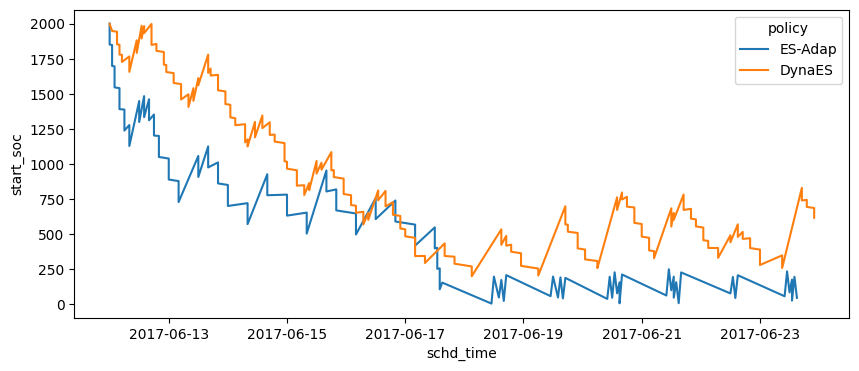

In [6]:
met_soc = metric_soc(load_sch(sch_path))
met_soc = met_soc.reset_index()

plt.figure(figsize=(10,4))
plt.plot()
sns.lineplot(data=met_soc, x='schd_time', y='start_soc', hue='policy', hue_order=['ES-Adap','DynaES'])
plt.show()